# Tanzania Water - Ternery Classifier Problem
***
***

This notebook contains the working code for the models and vizualisations used for the project. The aim of the project is to predict the functionality status ('functional', 'functional needs repair', and 'non-functional') of water wells in Tanzania. The dataset used is the 'df_clean.csv' file located in the repository, which is a cleaned version of the data obtained from the Driven Data website. 

First, a baseline model was created using a Decision Tree Classifier. This was then compared to a three other models: a Random Forest Classifier, an Adaptive Boosting Classifier, and a Gradient Boosting Classifier.

# Summary of Results

The evaluation of the models was based on the following metrics: accuracy, balanced accuracy, and area under the ROC curve.

In [26]:
import pandas as pd
results = {'Model':['DTC (Baseline)','RFC','ABC'],
           'Accuracy':[0.744,0.805,0.732],
           'Balanced_accuracy':[0.629,0.643,0.518],
           'AUC_F':[0.774,0.897,0.802],
           'AUC_FNR':[0.651,0.866,0.759],
           'AUC_NF':[0.805,0.921,0.827],
           'AUC_mean':[0.744,0.894,0.796]}
results_df = pd.DataFrame(results)
results_df.to_excel('results.xlsx')
results_df

,Model,Accuracy,Balanced_accuracy,AUC_F,AUC_FNR,AUC_NF,AUC_mean
0,DTC (Baseline),0.744,0.629,0.774,0.651,0.805,0.744
1,RFC,0.805,0.643,0.897,0.866,0.921,0.894
2,ABC,0.732,0.518,0.802,0.759,0.827,0.796


First, the relevant libraries and functions are imported and defined, and the dataframe is read and inspected.

In [27]:
# importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve,balanced_accuracy_score
skf = StratifiedKFold(n_splits=5,random_state=16,shuffle=True)

%matplotlib inline

In [28]:
# defining relevant functions for later use
def score_plotter(model,
                  training_set_X,
                  training_set_y,
                  validation_set_X,
                  validation_set_y,
                  model_name=None):
    
    """
    This function takes in a machine learning model and outputs a visialisation of the ROC curve,
    along with the AUC score for each of the classes. It is intended to be used as a summary evaluator
    for the models in this project.
    
    Args:
        model: the model to be evaluated
        training_set_X: the training set features
        training_set_y: the training set target
        validation_set_X: the validation set features
        validation_set_y: the validation set target
        model_name: the name of the type of model (eg: Random Forest Classifier), defaults to None
    """    
    
    # generating predictions   
    model_pred_train = model.predict(X_train)
    model_pred_proba_train = model.predict_proba(X_train)
    model_pred_val = model.predict(X_val)
    model_pred_proba_val = model.predict_proba(X_val)
    # converting targets to dummy variables   
    y_train_d = np.array(pd.get_dummies(y_train))
    y_val_d = np.array(pd.get_dummies(y_val))
    
    # generating roc curves for each class  
    fpr_0, tpr_0, thresholds_0 = roc_curve(y_val_d[:,0], model_pred_proba_val[:,0])
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_val_d[:,1], model_pred_proba_val[:,1])
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_val_d[:,2], model_pred_proba_val[:,2])
    
    # computing AUC scores for each class
    auc_0 = roc_auc_score(y_val_d[:,0], model_pred_proba_val[:,0])
    auc_1 = roc_auc_score(y_val_d[:,1], model_pred_proba_val[:,1])
    auc_2 = roc_auc_score(y_val_d[:,2], model_pred_proba_val[:,2])
    
    # generating plot figure
    plt.figure(figsize=(8,8))
    
    # plotting ROC curves for each class
    plt.plot([0, 1], [0, 1], label='Chance line', color='gray', linestyle='--')   
    plt.plot(fpr_0, tpr_0, label=f'Functional: AUC = {round(auc_0,3)}',color='seagreen')
    plt.plot(fpr_1, tpr_1, label=f'Functional needs repair: AUC = {round(auc_1,3)}',color='goldenrod')
    plt.plot(fpr_2, tpr_2, label=f'Non functional: AUC = {round(auc_2,3)}',color='maroon')
    
    # plot formatting (including mean AUC for the three classes)
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.legend(loc=4)
    plt.title(f'{model_name}: mean AUC = {round((auc_0+auc_1+auc_2)/3,3)}')
    plt.show()

In [29]:
# importing relevant functions
from functions.confusion_matrix import make_confusion_matrix

Note that the ***make_confusion_matrix*** function for visualising confusion matrices was found on the web and not created by the project team. Credit in its entirity is due to GitHub user DTrimarchi10. Please see https://github.com/DTrimarchi10/confusion_matrix

In [30]:
# loading and reading data
df = pd.read_csv('df_clean.csv')
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                59400 non-null  float64
 1   amount_tsh        59400 non-null  float64
 2   funder            59400 non-null  object 
 3   installer         59400 non-null  object 
 4   gps_height        59400 non-null  float64
 5   longitude         59400 non-null  float64
 6   latitude          59400 non-null  float64
 7   basin             59400 non-null  object 
 8   population        59400 non-null  float64
 9   permit            59400 non-null  object 
 10  extraction_type   59400 non-null  object 
 11  management        59400 non-null  object 
 12  management_group  59400 non-null  object 
 13  payment           59400 non-null  object 
 14  quality_group     59400 non-null  object 
 15  quantity          59400 non-null  object 
 16  source            59400 non-null  object

Next, the data is split into predictor and target variables, before dummy variables are encoded for all categorical variables.

In [31]:
# splitting target and predictor variables into separate dataframes
y = df['status_group']
X = df.drop('status_group', axis=1)

In [32]:
# creating dummy columns for categoricals
X_d = pd.get_dummies(X)

Finally, the data is split into training, validation, and testing sets.

In [33]:
X_tv, X_test, y_tv, y_test = train_test_split(X_d, y, test_size=0.25, random_state=16)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.25, random_state=16)

# Trial 1: Baseline

The baseline model will be a Decision Tree Classifier, run with no hyperparameter optimisation.

In [35]:
# importing relevant libraries
from sklearn.tree import DecisionTreeClassifier

In [36]:
# creating DTC and fitting to training data
dtc = DecisionTreeClassifier(random_state=16)
dtc_model = dtc.fit(X_train,y_train)

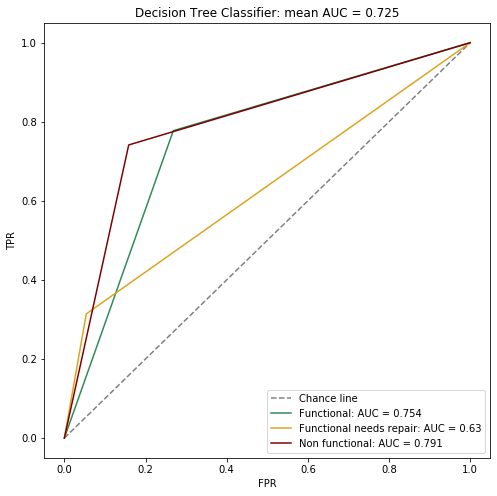

In [37]:
# generating the evaluation output for the baseline model using the score_plotter function defined above.
score_plotter(dtc_model,X_train,y_train,X_val,y_val,model_name='Decision Tree Classifier')

The baseline model does not perform particularly well, as expected. The AUC scores for the three classes are:

- Functional: 0.774
- Functional needs repair: 0.651
- Non functional: 0.805

And the mean AUC score across the three classes is 0.744.

# Trial 2: Random Forest Classifier

The next trial uses a Random Forest Classifier with hyperparameter optimisation.

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
forest = RandomForestClassifier(random_state=16)
rfc_model = forest.fit(X_train, y_train)

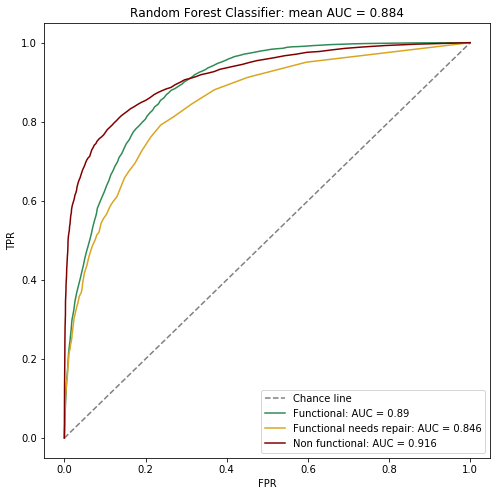

In [15]:
score_plotter(rfc_model,X_train,y_train,X_val,y_val,model_name='Random Forest Classifier')

The RFC performs significantly better than the baseline immediately. The AUC scores for the three classes are:

- Functional: 0.890
- Functional needs repair: 0.839
- Non functional: 0.914

And the mean AUC score across the three classes is 0.881.

### RFC: Search 1

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.7min finished


Best Hyperparameters:
---------------------
max_depth: 25
min_samples_leaf: 5
bootstrap: False


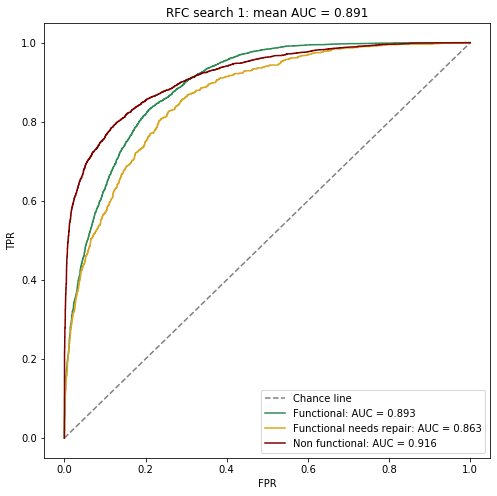

CPU times: user 11.9 s, sys: 234 ms, total: 12.1 s
Wall time: 2min 50s


In [17]:
%%time
# search 1 using the following hyperparameter ranges:
param_grid_rfc_search_1 = {'max_depth':[5,25,45],
                           'min_samples_leaf':[5,50,100],
                           'bootstrap': [True, False]}

opt_model_rfc_search_1 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_1,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

# fitting the optimised model
opt_model_rfc_search_1.fit(X_train,y_train)

# saving the best estimator
best_rfc_model_search_1 = opt_model_rfc_search_1.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_1.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_1.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_1.get_params()['bootstrap'])

# plotting the resulting ROC curve
score_plotter(best_rfc_model_search_1,X_train,y_train,X_val,y_val,model_name='RFC search 1')

From the above we see that the optimal parameters ***min_samples_leaf*** is on the edge of the range. For ***max_depth***, the optimal value is within the range, so the search will be refined. The result for the ***bootstrap*** hyperparameter is 'False', therefore it will be set to 'False' in the next search.

### RFC: Search 2

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.2min finished


Best Hyperparameters:
---------------------
max_depth: 25
min_samples_leaf: 5
bootstrap: False


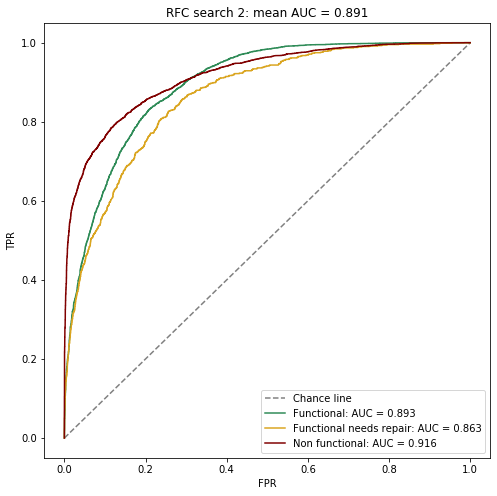

CPU times: user 11.5 s, sys: 108 ms, total: 11.6 s
Wall time: 2min 21s


In [18]:
%%time
param_grid_rfc_search_2 = {'max_depth':[15,25,35],
                           'min_samples_leaf':[5,15,25],
                           'bootstrap':[False]}

opt_model_rfc_search_2 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_2,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_2.fit(X_train,y_train)
best_rfc_model_search_2 = opt_model_rfc_search_2.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_2.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_2.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_2.get_params()['bootstrap'])

# plotting the resulting ROC curve
score_plotter(best_rfc_model_search_2,X_train,y_train,X_val,y_val,model_name='RFC search 2')

From the above we see that the parameters for ***max_depth*** and ***min_samples_leaf*** are both within the ranges. The search will continue to optimise the values.

### RFC: Search 3

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.7min finished


Best Hyperparameters:
---------------------
max_depth: 25
min_samples_leaf: 2
bootstrap: False


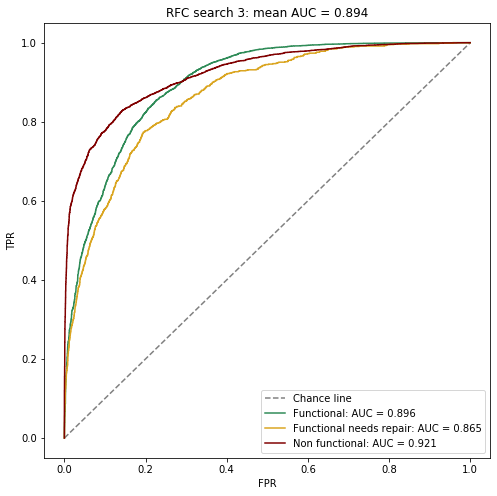

CPU times: user 13 s, sys: 158 ms, total: 13.2 s
Wall time: 4min 53s


In [19]:
%%time
param_grid_rfc_search_3 = {'max_depth':[20,25,30],
                           'min_samples_leaf':[2,5,8],
                           'bootstrap':[False]}

opt_model_rfc_search_3 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_3,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_3.fit(X_train,y_train)
best_rfc_model_search_3 = opt_model_rfc_search_3.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_3.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_3.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_3.get_params()['bootstrap'])

# plotting the resulting ROC curve
score_plotter(best_rfc_model_search_3,X_train,y_train,X_val,y_val,model_name='RFC search 3')

From the above we see that the parameters for ***max_depth*** and ***min_samples_leaf*** are still within the ranges. The search will continue to optimise the values.

### RFC: Search 4

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.8min finished


Best Hyperparameters:
---------------------
max_depth: 25
min_samples_leaf: 2
bootstrap: False


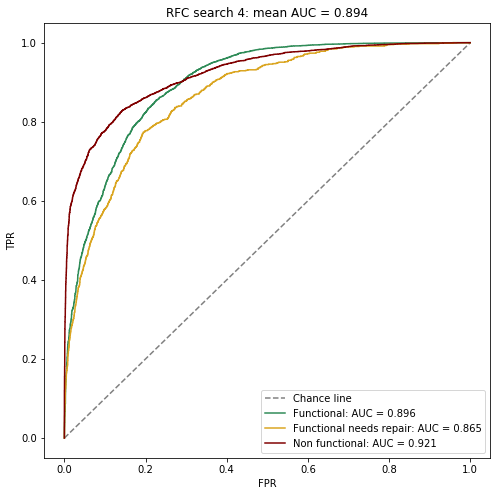

CPU times: user 13 s, sys: 161 ms, total: 13.1 s
Wall time: 3min 2s


In [20]:
%%time
param_grid_rfc_search_4 = {'max_depth':[22,25,28],
                           'min_samples_leaf':[2,3,4],
                           'bootstrap':[False]}

opt_model_rfc_search_4 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_4,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_4.fit(X_train,y_train)
best_rfc_model_search_4 = opt_model_rfc_search_4.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_4.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_4.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_4.get_params()['bootstrap'])

# plotting the resulting ROC curve
score_plotter(best_rfc_model_search_4,X_train,y_train,X_val,y_val,model_name='RFC search 4')

The search continues...

### RFC: Search 5

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.0min finished


Best Hyperparameters:
---------------------
max_depth: 27
min_samples_leaf: 2
bootstrap: False


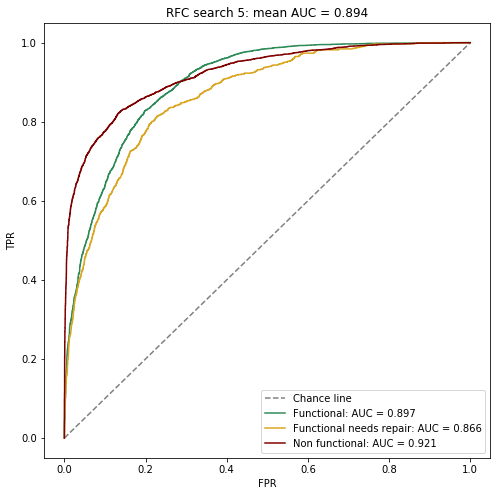

CPU times: user 15.1 s, sys: 299 ms, total: 15.4 s
Wall time: 3min 17s


In [25]:
%%time
param_grid_rfc_search_5 = {'max_depth':[23,25,27],
                           'min_samples_leaf':[1,2,3],
                           'bootstrap':[False]}

opt_model_rfc_search_5 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_5,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_5.fit(X_train,y_train)
best_rfc_model_search_5 = opt_model_rfc_search_5.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_5.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_5.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_5.get_params()['bootstrap'])

# plotting the resulting ROC curve
score_plotter(best_rfc_model_search_5,X_train,y_train,X_val,y_val,model_name='RFC search 5')

The value of 2 for ***min_samples_leaf*** is the optimal value. The search continues for ***max_depth***...

### RFC: Search 6

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Best Hyperparameters:
---------------------
max_depth: 27
min_samples_leaf: 2
bootstrap: False


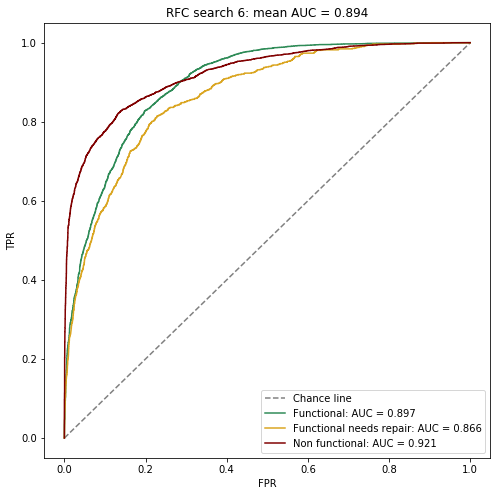

CPU times: user 12.9 s, sys: 149 ms, total: 13 s
Wall time: 1min 20s


In [26]:
%%time
param_grid_rfc_search_6 = {'max_depth':[25,27,29],
                           'min_samples_leaf':[2],
                           'bootstrap':[False]}

opt_model_rfc_search_6 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_6,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_6.fit(X_train,y_train)
best_rfc_model_search_6 = opt_model_rfc_search_6.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_6.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_6.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_6.get_params()['bootstrap'])

# plotting the resulting ROC curve
score_plotter(best_rfc_model_search_6,X_train,y_train,X_val,y_val,model_name='RFC search 6')

The search continues...

### RFC: Search 7

In [ ]:
%%time
param_grid_rfc_search_7 = {'max_depth':[26,27,28],
                           'min_samples_leaf':[2],
                           'bootstrap':[False]}

opt_model_rfc_search_7 = GridSearchCV(rfc_model,
                                      param_grid_rfc_search_7,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_rfc_search_7.fit(X_train,y_train)
best_rfc_model_search_7 = opt_model_rfc_search_7.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('max_depth:',best_rfc_model_search_7.get_params()['max_depth'])
print('min_samples_leaf:',best_rfc_model_search_7.get_params()['min_samples_leaf'])
print('bootstrap:',best_rfc_model_search_7.get_params()['bootstrap'])

# plotting the resulting ROC curve
score_plotter(best_rfc_model_search_7,X_train,y_train,X_val,y_val,model_name='RFC search 7')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The optimal value for ***max_depth*** has been located at 27. This search has therefore yielded the best model.

In [28]:
best_rfc_model = best_rfc_model_search_7

The hyperparameter-optimised RFC improves on the original RFC. The AUC scores for the three classes have increased as follows:

- Functional: from 0.890 to **0.897**
- Functional needs repair: from 0.839 to **0.866**
- Non functional: from 0.914 to **0.921**

And the mean AUC score across the three classes has increased from 0.881 to **0.894**.

# Trial 3: AdaBoost

The next trial uses an Adaptive Boost Classifier with hyperparameter optimisation.

In [29]:
from sklearn.ensemble import AdaBoostClassifier

In [30]:
abc = AdaBoostClassifier(random_state=16)
abc_model = abc.fit(X_train, y_train)

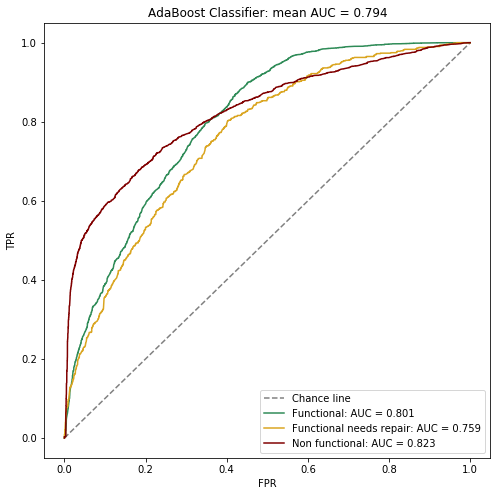

In [31]:
score_plotter(abc_model,X_train,y_train,X_val,y_val, model_name='AdaBoost Classifier')

The ABC performs significantly better than the baseline, but not quite as well as the RFC. The AUC scores for the three classes are:

- Functional: 0.801
- Functional needs repair: 0.759
- Non functional: 0.823

And the mean AUC score across the three classes is 0.794.

### ABC: Search 1

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


Best Hyperparameters:
---------------------
learning_rate: 0.61


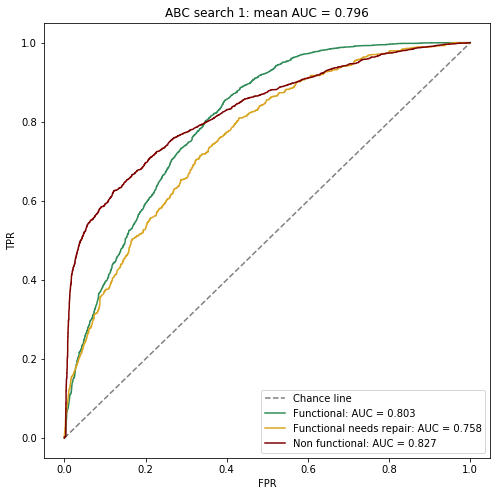

CPU times: user 7.09 s, sys: 236 ms, total: 7.32 s
Wall time: 2min 8s


In [32]:
%%time
# search 1 using the following hyperparameter ranges:
param_grid_abc_search_1 = {'learning_rate':[lr/100 for lr in range(1,100+1,10)]}

opt_model_abc_search_1 = GridSearchCV(abc_model,
                                      param_grid_abc_search_1,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

# fitting the optimised model
opt_model_abc_search_1.fit(X_train,y_train)

# saving the best estimator
best_abc_model_search_1 = opt_model_abc_search_1.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('learning_rate:',best_abc_model_search_1.get_params()['learning_rate'])

# plotting the resulting ROC curve
score_plotter(best_abc_model_search_1,X_train,y_train,X_val,y_val,model_name='ABC search 1')

### ABC: Search 2

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.4min finished


Best Hyperparameters:
---------------------
learning_rate: 0.66


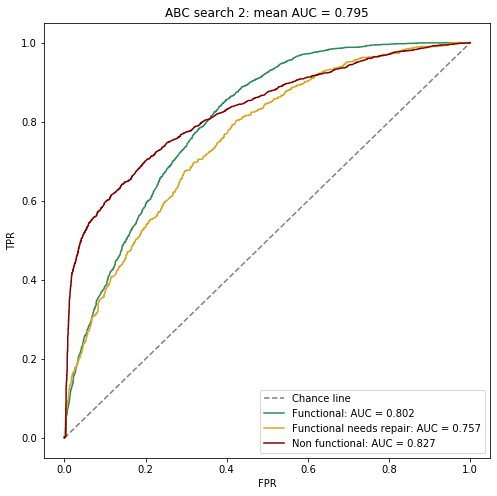

CPU times: user 6.97 s, sys: 227 ms, total: 7.2 s
Wall time: 1min 32s


In [33]:
%%time
param_grid_abc_search_2 = {'learning_rate':[0.55,0.58,0.6,0.62,0.64,0.66,0.68]}

opt_model_abc_search_2 = GridSearchCV(abc_model,
                                      param_grid_abc_search_2,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_abc_search_2.fit(X_train,y_train)

best_abc_model_search_2 = opt_model_abc_search_2.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('learning_rate:',best_abc_model_search_2.get_params()['learning_rate'])

# plotting the resulting ROC curve
score_plotter(best_abc_model_search_2,X_train,y_train,X_val,y_val,model_name='ABC search 2')

### ABC: Search 3

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.0min finished


Best Hyperparameters:
---------------------
learning_rate: 0.65


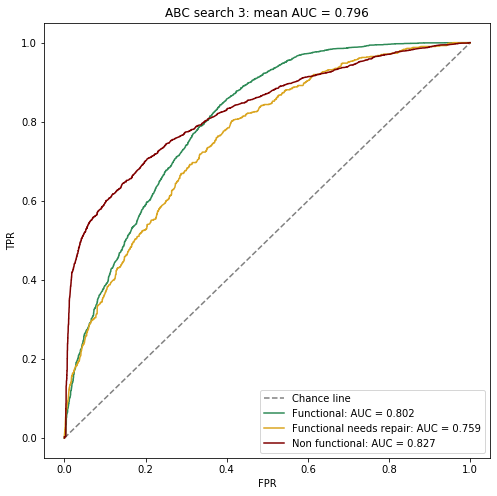

CPU times: user 7.07 s, sys: 238 ms, total: 7.31 s
Wall time: 1min 9s


In [34]:
%%time
param_grid_abc_search_3 = {'learning_rate':[0.64,0.65,0.66,0.67,0.68]}

opt_model_abc_search_3 = GridSearchCV(abc_model,
                                      param_grid_abc_search_3,
                                      cv=skf,
                                      scoring='accuracy',
                                      return_train_score=True,
                                      n_jobs=-1,
                                      verbose=1)

opt_model_abc_search_3.fit(X_train,y_train)

best_abc_model_search_3 = opt_model_abc_search_3.best_estimator_

# extracting best hyperparameter values
print('Best Hyperparameters:')
print('---------------------')
print('learning_rate:',best_abc_model_search_3.get_params()['learning_rate'])

# plotting the resulting ROC curve
score_plotter(best_abc_model_search_3,X_train,y_train,X_val,y_val,model_name='ABC search 3')

In [35]:
best_abc_model = best_abc_model_search_3

The hyperparameter-optimised ABC improves slightly on the original ABC. The AUC scores for the three classes have increased as follows:

- Functional: from 0.801 to **0.802**
- Functional needs repair: no change from 0.759 to **0.759**
- Non functional: from 0.823 to **0.827**

And the mean AUC score across the three classes has increased from 0.794 to **0.796**.

# Final Test

Now that the learners have been optimised, they will be subjected to the final test. 

### Baseline Model: Decision Tree Classifier

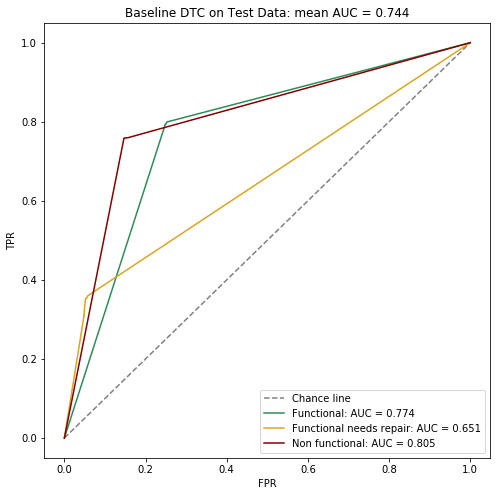

In [46]:
score_plotter(dtc_model,X_train,y_train,X_test,y_test,model_name='Baseline DTC on Test Data')

Here we see that the DTC does not perform particularly well on the test data.

In [47]:
# creating confusion matrix for the DTC model
dtc_cm = confusion_matrix(y_test,dtc_model.predict(X_test))

In [48]:
# creating category list for confusion matrix visualisation
cm_cats = ['functional', 'functional needs repair', 'non functional']

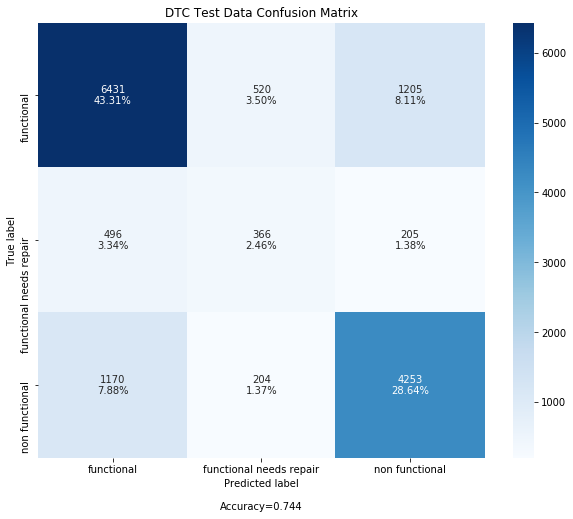

In [49]:
# generating the confusion matrix visualisation using Dtrimachi's function
make_confusion_matrix(dtc_cm, figsize=(10,8), categories=cm_cats, title='DTC Test Data Confusion Matrix')

In [70]:
print(classification_report(y_test,dtc_model.predict(X_test)))
print('Balanced accuracy:',round(balanced_accuracy_score(y_test,dtc_model.predict(X_test)),3))

                         precision    recall  f1-score   support

             functional       0.79      0.79      0.79      8156
functional needs repair       0.34      0.34      0.34      1067
         non functional       0.75      0.76      0.75      5627

               accuracy                           0.74     14850
              macro avg       0.63      0.63      0.63     14850
           weighted avg       0.74      0.74      0.74     14850

Balanced accuracy: 0.629


### Optimised Random Forest Classifier

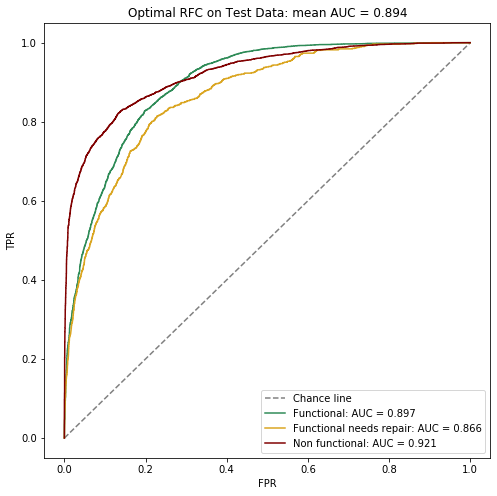

In [50]:
score_plotter(best_rfc_model,X_train,y_train,X_test,y_test,model_name='Optimal RFC on Test Data')

The optimised RFC performs just as well on the test data as it did on the validation data. The AUC for each class, as well as the mean AUC across all three, is higher than for the other models. Therefore this is the best performing model.

In [51]:
# creating confusion matrix for the optimised RFC model
best_rfc_cm = confusion_matrix(y_test,best_rfc_model.predict(X_test))

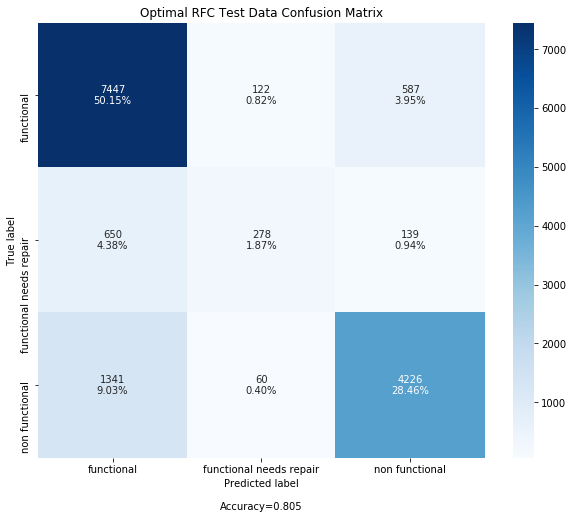

In [52]:
# generating the confusion matrix visualisation using Dtrimachi's function
make_confusion_matrix(best_rfc_cm, figsize=(10,8), categories=cm_cats, title='Optimal RFC Test Data Confusion Matrix')

In [71]:
print(classification_report(y_test,best_rfc_model.predict(X_test)))
print('Balanced accuracy:',round(balanced_accuracy_score(y_test,best_rfc_model.predict(X_test)),3))

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.85      8156
functional needs repair       0.60      0.26      0.36      1067
         non functional       0.85      0.75      0.80      5627

               accuracy                           0.80     14850
              macro avg       0.75      0.64      0.67     14850
           weighted avg       0.80      0.80      0.79     14850

Balanced accuracy: 0.642


### Optimised Adaptive Boost Classifier

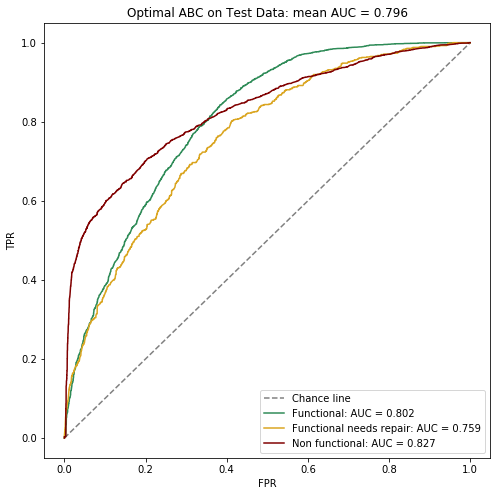

In [53]:
score_plotter(best_abc_model,X_train,y_train,X_test,y_test,model_name='Optimal ABC on Test Data')

The optimised ABC performs better than the baseline, but not quite as well as the optimised RFC.

In [54]:
# creating confusion matrix for the optimised ABC model
best_abc_cm = confusion_matrix(y_test,best_abc_model.predict(X_test))

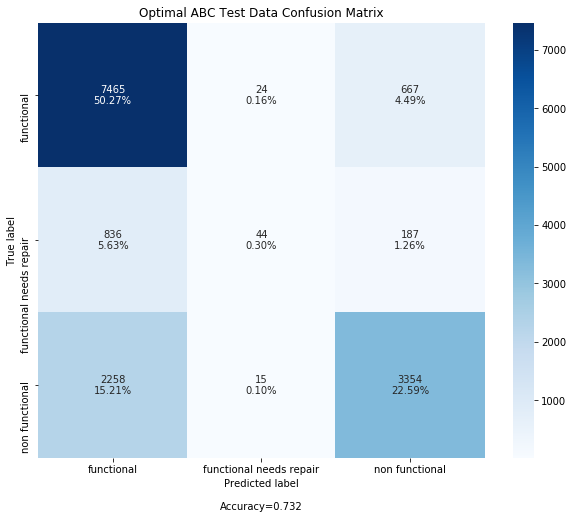

In [55]:
# generating the confusion matrix visualisation using Dtrimachi's function
make_confusion_matrix(best_abc_cm, figsize=(10,8), categories=cm_cats, title='Optimal ABC Test Data Confusion Matrix')

In [72]:
print(classification_report(y_test,best_abc_model.predict(X_test)))
print('Balanced accuracy:',round(balanced_accuracy_score(y_test,best_abc_model.predict(X_test)),3))

                         precision    recall  f1-score   support

             functional       0.71      0.92      0.80      8156
functional needs repair       0.53      0.04      0.08      1067
         non functional       0.80      0.60      0.68      5627

               accuracy                           0.73     14850
              macro avg       0.68      0.52      0.52     14850
           weighted avg       0.73      0.73      0.70     14850

Balanced accuracy: 0.518


### Visualising Feature Importance for Best Model

In [54]:
best_model_overall = RandomForestClassifier(random_state=16,max_depth=27,min_samples_leaf=2,bootstrap=False)
top_model = best_model_overall.fit(X_test, y_test)

In [56]:
importance_dict = {'Feature':X_test.columns,'Importance':top_model.feature_importances_}
importance_df = pd.DataFrame(importance_dict)

In [61]:
top_5 = importance_df.sort_values(by=['Importance'],ascending=False)[0:5]
top_5

,Feature,Importance
80,quantity_dry,0.121055
3,longitude,0.084539
4,latitude,0.083287
6,age_years,0.054921
2,gps_height,0.052052


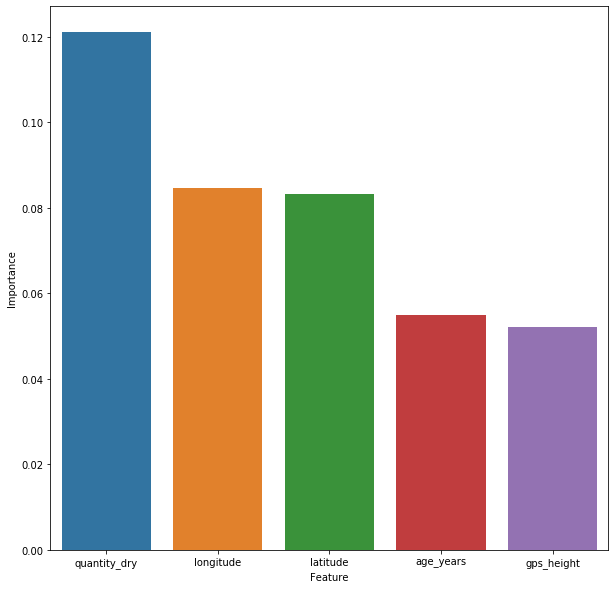

In [71]:
plt.figure(figsize=(10,10))
top_5_features = top_5['Feature']
top_5_importance = top_5['Importance']
sns.barplot(top_5_features,top_5_importance)
plt.show()